# TPU CODE #

In [ ]:
import tensorflow as tf
import json
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

# Enable TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # detect TPU
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)  # create TPU strategy
    print("TPU initialized")
except ValueError:
    strategy = tf.distribute.get_strategy()  # fallback for CPU/GPU
    print("Using CPU/GPU strategy")


IMG_HEIGHT = 227
IMG_WIDTH = 227
BATCH_SIZE = 128  # Larger batch size for TPU

with open("/kaggle/input/imagenet100/Labels.json") as f:
    labels = json.load(f)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_dirs = ["/kaggle/input/imagenet100/train.X1",
              "/kaggle/input/imagenet100/train.X2",
              "/kaggle/input/imagenet100/train.X3",
              "/kaggle/input/imagenet100/train.X4"]

train_generators = [train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=list(labels.keys())
) for train_dir in train_dirs]

def combined_generator_to_dataset(generators):
    def generator():
        for gen in generators:
            for data, labels in gen:
                yield data, labels
    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(None, IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, len(labels)), dtype=tf.float32)
        )
    )

train_dataset = combined_generator_to_dataset(train_generators).shuffle(1000).repeat().batch(BATCH_SIZE)
val_generator = val_datagen.flow_from_directory(
    directory="/kaggle/input/imagenet100/val.X",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=list(labels.keys())
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: ((data, label) for data, label in val_generator),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(labels)), dtype=tf.float32)
    )
).repeat().batch(BATCH_SIZE)

checkpoint_callback = ModelCheckpoint(
    filepath="best_model.weights.h5",  # Path to save the model
    monitor="val_accuracy",    # Monitor validation accuracy
    mode="max",                # Save model with max validation accuracy
    save_best_only=True,       # Save only the best model
    save_weights_only=True,    # Save only weights, not entire model structure
    verbose=1
)

with strategy.scope():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        
        tf.keras.layers.Conv2D(256, (5, 5), padding="same", activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        
        tf.keras.layers.Conv2D(384, (3, 3), padding="same", activation='relu'),
        tf.keras.layers.Conv2D(384, (3, 3), padding="same", activation='relu'),
        tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(len(labels), activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'mse', 'mae'])

steps_per_epoch = sum(gen.samples // BATCH_SIZE for gen in train_generators)
validation_steps = val_generator.samples // BATCH_SIZE


EPOCHS = 7 # Adjust as per need
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback]  # Add the checkpoint callback
)


# GPU CODE #  

In [ ]:
import tensorflow as tf
import json
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_HEIGHT = 227
IMG_WIDTH = 227
BATCH_SIZE = 32

with open("/kaggle/input/imagenet100/Labels.json") as f:
    labels = json.load(f)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_dirs = ["/kaggle/input/imagenet100/train.X1",
              "/kaggle/input/imagenet100/train.X2",
              "/kaggle/input/imagenet100/train.X3",
              "/kaggle/input/imagenet100/train.X4"]

train_generators = [train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=list(labels.keys())
) for train_dir in train_dirs]

def combined_generator(generators):
    while True:
        for gen in generators:
            for data, labels in gen:
                yield data, labels

train_generator = combined_generator(train_generators)

val_generator = val_datagen.flow_from_directory(
    directory="/kaggle/input/imagenet100/val.X",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=list(labels.keys())
)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    tf.keras.layers.Conv2D(256, (5, 5), padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    tf.keras.layers.Conv2D(384, (3, 3), padding="same", activation='relu'),
    tf.keras.layers.Conv2D(384, (3, 3), padding="same", activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(labels), activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'mse', 'mae'])

# Estimate steps per epoch based on the number of images in train.X directories
steps_per_epoch = sum(gen.samples // BATCH_SIZE for gen in train_generators)
validation_steps = val_generator.samples // BATCH_SIZE

EPOCHS = 7 # Adjust as per need
model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)
model.save("/kaggle/working/alexnet-5epoch.h5")

In [3]:
import tensorflow as tf
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_HEIGHT = 227
IMG_WIDTH = 227
BATCH_SIZE = 128

with open("/kaggle/input/imagenet100/Labels.json") as f:
    labels = json.load(f)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    directory="/kaggle/input/imagenet100/val.X",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=list(labels.keys())
)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    tf.keras.layers.Conv2D(256, (5, 5), padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    tf.keras.layers.Conv2D(384, (3, 3), padding="same", activation='relu'),
    tf.keras.layers.Conv2D(384, (3, 3), padding="same", activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(labels), activation='softmax')
])

model.load_weights("/kaggle/input/alexnet-7epoch/tensorflow2/default/1/alexnet-7epoch.h5")

# Compile the model (required for evaluation)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'mse', 'mae'])

# Evaluate the model on the validation dataset using the generator directly
evaluation = model.evaluate(val_generator)
print(f"Validation Loss: {evaluation[0]}")
print(f"Validation Accuracy: {evaluation[1]}")


Found 5000 images belonging to 100 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731171801.529575     108 service.cc:145] XLA service 0x7ad05800c070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731171801.529654     108 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731171801.529659     108 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 2/40 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.2070 - loss: 22.5547 - mae: 0.0159 - mse: 0.0128

I0000 00:00:1731171808.212098     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.1817 - loss: 24.1180 - mae: 0.0165 - mse: 0.0134
Validation Loss: 24.351606369018555
Validation Accuracy: 0.17880000174045563


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


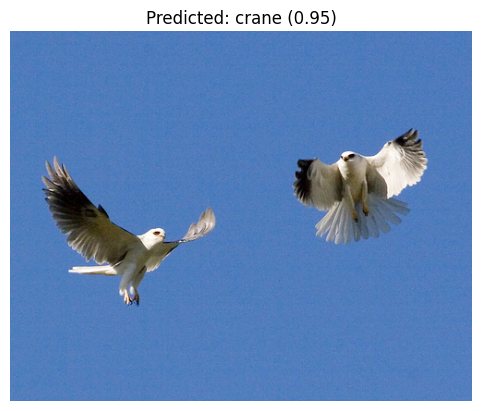

In [12]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import json
import matplotlib.pyplot as plt

IMG_HEIGHT = 227
IMG_WIDTH = 227

# Load labels from Labels.json
with open("/kaggle/input/imagenet100/Labels.json") as f:
    labels = json.load(f)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    tf.keras.layers.Conv2D(256, (5, 5), padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    tf.keras.layers.Conv2D(384, (3, 3), padding="same", activation='relu'),
    tf.keras.layers.Conv2D(384, (3, 3), padding="same", activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(labels), activation='softmax')
])

model.load_weights("/kaggle/input/alexnet-7epoch/tensorflow2/default/1/alexnet-7epoch.h5")

def predict_and_display(image_path):
    img = image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    
    class_keys = list(labels.keys())
    predicted_class_key = class_keys[predicted_class_index]
    predicted_class_label = labels[predicted_class_key]
    confidence = predictions[0][predicted_class_index]

    plt.imshow(image.load_img(image_path))
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class_label} ({confidence:.2f})")
    plt.show()

# Test on a sample image
predict_and_display("/kaggle/input/imagenet100/val.X/n01608432/ILSVRC2012_val_00000073.JPEG")
